## Final Proyect
### Nuclio Digital School - Data Science Masters (2023)
#### Guillermo Anderson & Ricardo Navarro



In [1]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Guille Reads

In [ ]:
product = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project Nuclio/products_df.csv', index_col = 0)

In [ ]:
ca_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project Nuclio/commercial_activity_df.csv', index_col = 0)

In [ ]:
socio = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Project Nuclio/sociodemographic_df.csv', index_col = 0)

In [2]:
# Locally
path = os.path.dirname(os.path.abspath('Final_Proyect_Guillermo_Ricardo.ipynb'))
os.chdir(path)
path

'c:\\Users\\ander\\Desktop\\Nuclio Digital School\\Proyecto Final'

In [3]:

product = pd.read_csv('products_df.csv', sep = ',', index_col= 0)

In [4]:
socio =  pd.read_csv('sociodemographic_df.csv' , sep = ',', index_col= 0)

In [5]:
ca_df = pd.read_csv('commercial_activity_df.csv', sep = ',', index_col = 0)

#### Ricardo Reads

In [ ]:
product = pd.read_csv('/content/drive/MyDrive/Nuclio Riki/product.csv', index_col = 0)

In [ ]:
ca_df = pd.read_csv('/content/drive/MyDrive/Nuclio Riki/ca_df.csv', index_col = 0)

In [ ]:
socio = pd.read_csv('/content/drive/MyDrive/Nuclio Riki/socio.csv', index_col = 0)

### Dataframe visualization

We have determined that the three dataframes have the same number of rows and they are connected by two variables: 'pk_cid' and 'pk_partition'. We generate a fourth dataframe consisting of all the information

In [6]:
#We generate a fourth dataframe consisting of all the available information

soc_ca = pd.merge(socio, ca_df, on = ['pk_cid','pk_partition'])

final_df = pd.merge(soc_ca, product, on = ['pk_cid','pk_partition'])

Bob's core task is to classify EasyMoney's clients and recommend products to 10 thousand of them based on their likelihood to purchase. He is also responsible for estimating the company's revenue after this recommendation.

#### Selecting the Data we will use

The variable "pk_partition" represents monthly snapshots of the company's database. We will utilize the latest partition available as it provides the most recent status of the clients' purchases.

In [7]:
# Identify last partition
final_df['pk_partition'].max()

'2019-05-28'

In [8]:
last_partition = final_df[final_df['pk_partition'] == final_df['pk_partition'].max()]
last_partition.shape

(442995, 27)

In [9]:
#We do the same for the product table only
last_partition_product = product[product['pk_partition'] == product['pk_partition'].max()]

In [10]:
names = ["ID","Partition", 'Short-term_deposit', 'Loans', 'Mortgage',
       'Funds', 'Securities', 'Long-term_Deposit', 'Account_pp',
       'Credit_Card', 'Payroll', 'Pension_Plan', 'Payroll_Account',
       'Crypto_Account', 'Debit_Card', 'Account_p', 'Account']

In [11]:
#We change the name to ease human-parsing
last_partition_product  = last_partition_product .rename(columns = dict(zip(last_partition_product .columns, names)))

In [12]:
#We check for duplicated clients in the last partition

np.unique(last_partition['pk_cid'],return_counts = True)[1].max() 

# Since MAX equals to 1, it means no single client appears more than once in the last partition

1

In [13]:
#We check for deceased and inactive clients

print(np.unique(last_partition['deceased'], return_counts = True))
last_partition[last_partition['deceased'] == "S"].sample(5) 

#We see that Deceased clients have purchase history, so we will include them in the clustering

(array(['N', 'S'], dtype=object), array([442909,     86], dtype=int64))


,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5582005,1383921,2019-05-28,ES,28.0,V,45,S,131619.12,2018-02-23,KHL,...,1,0,0,0.0,0.0,0,1,0,0,1
5591404,1298008,2019-05-28,ES,18.0,H,83,S,NaN,2017-08-21,KAT,...,0,0,0,0.0,0.0,0,0,0,0,0
5823916,1028045,2019-05-28,ES,8.0,V,26,S,164161.65,2015-07-23,KHE,...,0,0,0,0.0,0.0,0,0,0,0,1
5832627,1012099,2019-05-28,ES,28.0,H,89,S,185459.73,2015-04-13,KFA,...,0,0,0,0.0,0.0,0,0,0,0,0
5735684,1467278,2019-05-28,ES,8.0,V,68,S,NaN,2018-10-02,KHM,...,0,0,0,0.0,0.0,0,0,0,0,0


In [14]:
print(np.unique(last_partition['active_customer'], return_counts = True))
last_partition[last_partition['active_customer'] == 0]
print("Inactive customers make", last_partition[last_partition['active_customer'] == 0].shape[0]/last_partition['active_customer'].shape[0]*100, "% of the totals clients in the last partition")


(array([0., 1.]), array([271427, 171568], dtype=int64))
Inactive customers make 61.27089470535785 % of the totals clients in the last partition


We have three distinct product categories: Saving, Financing and Account

In [15]:
dictionary = {"Savings":["Short-term_deposit",'Funds','Securities','Long-term_Deposit','Pension_Plan'],
              'Financing':['Loans','Mortgage','Credit_Card','Debit_Card'],
              "Account":['Account_pp','Payroll','Payroll_Account','Crypto_Account','Account_p','Account']
              }

In [16]:
Products_noID = last_partition_product.iloc[:,2:]

In [17]:
def sum_grouped_columns(cols):
    return Products_noID[cols].sum(axis=1)

After several clustering, we lastly chose to group the client types based uniquely on their purchase history; i.e How much products of each category they have purchased in the last partition

In [18]:
total_purchases = pd.DataFrame({key: sum_grouped_columns(cols) for key, cols in dictionary.items()})
total_purchases["ID"] = last_partition_product['ID']

In [19]:
total_purchases.head()

,Savings,Financing,Account,ID
12715896,0.0,0,1.0,657826
12715899,0.0,0,0.0,657817
12715982,1.0,2,3.0,657986
12716026,1.0,0,1.0,657905
12716082,0.0,0,1.0,657336


With the above table, we will cluster the clients and keep their ID for marketing purposes

#### Generating new variables

In the latest partition of the company, there are deceased clients and a significant percentage (61%) of inactive clients. Despite their status, we will utilize their purchase history to determine client types. When recommending products, we will exclude both deceased and inactive clients.

##### Product sold per client

In [21]:
last_partition.head()

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,...,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
5519929,657826,2019-05-28,ES,25.0,H,44,N,54493.38,2015-05-24,013,...,0,0,0,0.0,0.0,0,0,0,0,1
5519930,657817,2019-05-28,ES,8.0,V,32,N,NaN,2019-05-12,NaN,...,0,0,0,0.0,0.0,0,0,0,0,0
5519931,657986,2019-05-28,ES,41.0,H,39,N,100993.17,2016-02-18,KAF,...,0,0,1,1.0,1.0,1,1,1,0,0
5519932,657905,2019-05-28,ES,28.0,H,85,N,154059.09,2017-02-07,KAT,...,1,0,0,0.0,0.0,0,0,0,0,1
5519933,657336,2019-05-28,ES,28.0,V,38,N,NaN,2019-03-28,KAT,...,0,0,0,0.0,0.0,0,0,0,0,1


In [24]:
products_sold = last_partition_product[['Short-term_deposit', 'Loans', 'Mortgage',
       'Funds', 'Securities', 'Long-term_Deposit', 'Account_pp',
       'Credit_Card', 'Payroll', 'Pension_Plan', 'Payroll_Account',
       'Crypto_Account', 'Debit_Card', 'Account_p', 'Account']].sum().sort_values()
products_sold

Account_pp                 0.0
Short-term_deposit         2.0
Account_p                  2.0
Mortgage                  23.0
Loans                     30.0
Funds                   1315.0
Securities              1789.0
Credit_Card             4801.0
Long-term_Deposit       6129.0
Payroll                16333.0
Pension_Plan           17353.0
Crypto_Account         24751.0
Payroll_Account        26529.0
Debit_Card             43261.0
Account               296380.0
dtype: float64

In [25]:
px.bar(products_sold,
    title = "Products sold in May 2019" , labels = {'index':'', 'value':'Number of Products'})

Here we see regular accounts is the most sold product in the EM repertoire

##### Longevity

We also created a variable that calculates the time the clients have been in the company based on their presence in the last partition substracted by the entry days, and expressed in months. Initially we created clusters using this variables, however we ended up using it for post-clustering analyses

In [26]:
from dateutil.relativedelta import relativedelta
import datetime

In [29]:
#We also transofrmed dates from objects to datetime objects

last_partition['pk_partition'] = pd.to_datetime(last_partition['pk_partition'], errors = 'coerce')
last_partition['entry_date'] = pd.to_datetime(last_partition['entry_date'], errors = 'coerce')

C:\Users\ander\AppData\Local\Temp\ipykernel_43520\3087389646.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ander\AppData\Local\Temp\ipykernel_43520\3087389646.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
last_partition['entry_date'].mean()

Timestamp('2017-05-19 03:03:58.519745792')

In [31]:
last_partition['entry_date'].fillna(last_partition['entry_date'].mean(), inplace = True) # This was done to eliminate the 1000 missing NaN

C:\Users\ander\AppData\Local\Temp\ipykernel_43520\213984706.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
recency_ID = last_partition.iloc[:,:9].drop(columns = ['country_id','region_code','gender','age','deceased','salary'])

In [35]:
# We would like to see the longevity expresed in number of months in the company

longevity = recency_ID.apply(lambda row: (row['entry_date'].year - row['pk_partition'].year) * 12 +
                                    (row['entry_date'].month - row['pk_partition'].month), axis=1).abs()


The above array shows each client and the number of months in the company (longevity). Even though this variable won't define the future cluster, we will use it post-hoc to recommend products to clients

### Client types. Clustering Using K-means

In [39]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification

from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot as plt
from pylab import rcParams

We were asked to group clients based on 7 groups. We did however several clusters including all sort of variables, including an RFM segmentation. Ultimatedly, we agreed upong performing a KMeans clustering, using only 5 groups and, using the purchase history of the clients as shown below. The demographics will be later used for the recommendation

In [37]:
total_purchases.head()

,Savings,Financing,Account,ID
12715896,0.0,0,1.0,657826
12715899,0.0,0,0.0,657817
12715982,1.0,2,3.0,657986
12716026,1.0,0,1.0,657905
12716082,0.0,0,1.0,657336


In [62]:
kmeans_5 = KMeans(n_clusters = 5) ### 
cluster_samples_5 = total_purchases.drop(columns = ["ID"]).sample(n = 442995, random_state = 42)#.fillna(0)
X_5 = cluster_samples_5.values#.iloc[:, 2:].values
kmeans_5.fit(X_5)

c:\Users\ander\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=5)

In [63]:
label_5 = kmeans_5.labels_
label_5

cluster_samples_5['label'] = label_5
yhat_5 = kmeans_5.predict(X_5)
clusters_5 = unique(yhat_5)

In [58]:
cluster_samples_5.groupby('label').mean()

,Savings,Financing,Account
label,,,
0,0.014835,0.000000,1.000000
1,0.011131,0.013689,0.000000
2,0.036253,1.045293,1.115132
3,0.467128,0.000000,2.035469
4,1.092081,1.123453,2.303120


In [64]:
px.bar(cluster_samples_5.groupby('label').mean(), barmode = 'group')

The above barplot remain as proof that with every iteration of the code, the order of the cluster changes. Even though we had a random_state set (42), everytime we started the notebook, the clusters changed position. Try it out, by running the KMeans line again and reploting the barplot.

We solved this by storing the client_type dataframe to a CSV file after incorporating relevant information.

In [88]:
client_types_ = total_purchases.copy()

In [89]:
client_types_['Cluster'] = cluster_samples_5['label']


In [90]:
client_types_.head()

,Savings,Financing,Account,ID,Cluster
12715896,0.0,0,1.0,657826,2
12715899,0.0,0,0.0,657817,1
12715982,1.0,2,3.0,657986,0
12716026,1.0,0,1.0,657905,2
12716082,0.0,0,1.0,657336,2


Since we now have defined to which cluster each client belongs, we can incorporate relevant information about the clients

In [82]:
last_partition.rename(columns = {'pk_cid':'ID'}, inplace = True)

C:\Users\ander\AppData\Local\Temp\ipykernel_43520\623402259.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
client_types_ = pd.merge(client_types_, last_partition[
    ['age','gender','salary','region_code','ID', 'deceased']], on = 'ID')

In [75]:
#client_types_ = pd.merge(client_types_, longevity[['Longevity','ID']], on = 'ID')

In [92]:
client_types_ = pd.merge(client_types_, last_partition[['ID','active_customer']], on = "ID")

In [93]:
client_types_.head(10)

,Savings,Financing,Account,ID,Cluster,age,gender,salary,region_code,deceased,active_customer
0,0.0,0,1.0,657826,2,44,H,54493.38,25.0,N,1.0
1,0.0,0,0.0,657817,1,32,V,NaN,8.0,N,0.0
2,1.0,2,3.0,657986,0,39,H,100993.17,41.0,N,1.0
3,1.0,0,1.0,657905,2,85,H,154059.09,28.0,N,1.0
4,0.0,0,1.0,657336,2,38,V,NaN,28.0,N,1.0
5,0.0,0,0.0,657147,1,62,H,104881.71,28.0,N,0.0
6,1.0,2,3.0,658184,0,42,V,183036.72,28.0,N,1.0
7,1.0,0,0.0,658576,1,78,H,81977.58,16.0,N,1.0
8,0.0,0,1.0,655774,2,37,H,NaN,15.0,N,1.0
9,0.0,0,0.0,655419,1,54,H,157268.85,28.0,N,0.0


Again, to avoid the aforementioned issue with the cluster changing positions. We had store the clients table into a CSV file

In [ ]:
#client_types.to_csv('client_types.csv', sep = ',', index=True)

### Client types

In [94]:
#Guillermo
client_types = pd.read_csv('client_types.csv', sep = ',', index_col = 0)

#Ricardo
#client_types = pd.read_csv('/content/drive/MyDrive/Nuclio Riki/client_types.csv', index_col = 0)

In [96]:
client_types.head()

,Savings,Financing,Account,ID,Cluster,age,gender,salary,region_code,Longevity,active_customer
0,0.0,0,1.0,657826,2,44,H,54493.38,25.0,48,1.0
1,0.0,0,0.0,657817,0,32,V,NaN,8.0,0,0.0
2,1.0,2,3.0,657986,3,39,H,100993.17,41.0,39,1.0
3,1.0,0,1.0,657905,4,85,H,154059.09,28.0,27,1.0
4,0.0,0,1.0,657336,2,38,V,NaN,28.0,2,1.0


Based on the calculations using the K-mean algorithm, we determined 5 client types that we named:

In [97]:
cluster_names = {0:'Ghosts', 1:'Cash-Flow',2:'One-Account',3:'Hot Clients', 4:'Anti-Financing'}
client_types['Cluster_names'] = client_types['Cluster'].replace(cluster_names)

We also incorporated variables such as Gender, Salary and the region code, in order to determined whether there is a sub-population of clients in the mentioned clusters

In [98]:
client_types.head()

,Savings,Financing,Account,ID,Cluster,age,gender,salary,region_code,Longevity,active_customer,Cluster_names
0,0.0,0,1.0,657826,2,44,H,54493.38,25.0,48,1.0,One-Account
1,0.0,0,0.0,657817,0,32,V,NaN,8.0,0,0.0,Ghosts
2,1.0,2,3.0,657986,3,39,H,100993.17,41.0,39,1.0,Hot Clients
3,1.0,0,1.0,657905,4,85,H,154059.09,28.0,27,1.0,Anti-Financing
4,0.0,0,1.0,657336,2,38,V,NaN,28.0,2,1.0,One-Account


In [99]:
px.bar(client_types.groupby('Cluster_names')[['Savings','Financing','Account']].mean(), barmode = 'group', title = 'Mean product quantity', width = 800)

In [100]:
print('there are', client_types[client_types['Cluster_names'] == 'Ghosts']['ID'].count(), 'Ghost clients')

there are 114181 Ghost clients


The five clusters are as follows:

1. Anti-Financing: Clients with multiple EM accounts who are not interested in savings products and show reluctance to invest in financing tools.

2. Cash-Flow: Clients without savings, typically possessing one account and one financing tool.

3. Ghosts: Clients who have signed up with EasyMoney but have not made any product purchases. This group will not be used recommendations, and efforts are focused on engaged clients instead of reactivating this group.

4. Hot Clients: Our Loyal customers who have purchased at least one financing tool, one savings product, and generally hold a minimum of two accounts.

5. One-Account: Clients with only one account with EasyMoney.

In [101]:
px.bar(client_types.groupby("Cluster_names")['ID'].count(), title = 'Number of Clients per Cluster', text_auto= 'outside', width = 800)

In [102]:
client_types[client_types['Financing'] == 0].groupby('Cluster_names').count()

,Savings,Financing,Account,ID,Cluster,age,gender,salary,region_code,Longevity,active_customer
Cluster_names,,,,,,,,,,,
Anti-Financing,19814,19814,19814,19814,19814,19814,19814,13934,19787,19814,19814
Ghosts,112618,112618,112618,112618,112618,112618,112618,68606,112577,112618,112618
Hot Clients,123,123,123,123,123,123,123,95,123,123,123
One-Account,265571,265571,265571,265571,265571,265571,265570,180649,265506,265571,265571


### Determining variables of importance

As part of the marketing stratergy, the recommendations will be targeted using specific demographic should there be a subgroup within the clusters.

#### Gender

In [103]:
gender_prop = client_types.groupby('Cluster_names')['gender'].describe().iloc[:,3]/client_types.groupby('Cluster_names')['gender'].describe().iloc[:,0]*100
gender_prop = pd.DataFrame(gender_prop, columns= ["Male"])
gender_prop['Female'] = 100 - gender_prop['Male']


In [105]:
gender_prop = gender_prop.reset_index()
gender_prop

,index,Cluster_names,Male,Female
0,0,Anti-Financing,56.677097,43.322903
1,1,Cash-Flow,56.287275,43.712725
2,2,Ghosts,50.057365,49.942635
3,3,Hot Clients,55.496975,44.503025
4,4,One-Account,53.797116,46.202884


In [106]:
px.area(gender_prop, x  = 'Cluster_names', y = ['Male','Female'], title = 'Percentage of genders',
       labels = {'Cluster_names': 'Client types', 'value': 'Proportion [%]'}, width = 800)

Gender does not play a major role in dividing the clusters

#### Age

In [107]:
age_prop = client_types.groupby('Cluster_names')['age'].describe()#/client_types.groupby('Cluster_names')['gender'].describe().iloc[:,0]*100


In [108]:
age_prop['mean']

Cluster_names
Anti-Financing    43.445998
Cash-Flow         37.288741
Ghosts            31.141232
Hot Clients       38.619965
One-Account       27.926178
Name: mean, dtype: float64

In [109]:
px.bar(age_prop, x = age_prop.index, y = age_prop['mean'], error_y = age_prop['std'],
       title = 'Age proportions',
       labels = {'mean':"Client's age", 'Cluster_names':'Client types'}, width = 800)

Even though the means of the groups differ, we cannot claim significant difference between the groups based on the St.Dev of each groups. We conlcude that Age is not a specific metric of the clusters

#### Longevity

In [110]:
longevity = client_types.groupby('Cluster_names')['Longevity'].describe()
longevity

,count,mean,std,min,25%,50%,75%,max
Cluster_names,,,,,,,,
Anti-Financing,19814.0,24.884627,15.111317,0.0,11.0,23.0,39.0,52.0
Cash-Flow,31859.0,23.360652,13.896515,0.0,11.0,22.0,34.0,52.0
Ghosts,114181.0,21.554471,14.149250,0.0,8.0,19.0,31.0,52.0
Hot Clients,11570.0,26.829213,13.958351,0.0,16.0,27.0,39.0,52.0
One-Account,265571.0,24.799952,14.047056,0.0,10.0,22.0,34.0,52.0


In [111]:
px.bar(longevity, x = age_prop.index, y = longevity['mean'], error_y = longevity['std'],
       title = 'Longevity',
       labels = {'mean':"Client's longevity [mo]", 'Cluster_names':'Client types'}, width = 800)

We observe that Longevity does not play a major roll, and there are both old and new clients in all groups. This also answers the question whether our products are purchased by newer or older clients. There does not seem to be any difference

#### Recommendation

Based on the client types, we will generate our recomentadions, however, we will first drop the inactive accounts and the deceased clients.

In [113]:
recommendation_df = client_types[client_types['active_customer'] == 1]
#recommendation_df = client_types[client_types['deceased'] == 1]

In [114]:
recommendation_df.groupby('Cluster').count()

,Savings,Financing,Account,ID,age,gender,salary,region_code,Longevity,active_customer,Cluster_names
Cluster,,,,,,,,,,,
0,7582,7582,7582,7582,7582,7582,4714,7579,7582,7582,7582
1,31714,31714,31714,31714,31714,31713,22035,31690,31714,31714,31714
2,101597,101597,101597,101597,101597,101596,64726,101552,101597,101597,101597
3,11570,11570,11570,11570,11570,11570,8798,11566,11570,11570,11570
4,19105,19105,19105,19105,19105,19105,13381,19078,19105,19105,19105


In [116]:
px.bar(recommendation_df.groupby("Cluster_names")['ID'].count(), title = 'Number of Clients per Cluster', text_auto= 'outside', width = 800)

In [117]:
px.bar(client_types.groupby('Cluster_names')[['Savings','Financing','Account']].mean(), 
       barmode = 'group', title = 'Client table', width = 800)

#### Hot Clients

In [118]:
hot_clients = recommendation_df[recommendation_df['Cluster_names'] == "Hot Clients"]

In [119]:
hot_clients.head()

,Savings,Financing,Account,ID,Cluster,age,gender,salary,region_code,Longevity,active_customer,Cluster_names
2,1.0,2,3.0,657986,3,39,H,100993.17,41.0,39,1.0,Hot Clients
6,1.0,2,3.0,658184,3,42,V,183036.72,28.0,48,1.0,Hot Clients
16,1.0,2,2.0,656415,3,32,V,143418.03,28.0,51,1.0,Hot Clients
27,1.0,1,2.0,659236,3,62,V,220538.61,28.0,41,1.0,Hot Clients
35,1.0,1,2.0,650478,3,86,H,90712.98,28.0,8,1.0,Hot Clients


In [120]:
print("Hot Clients without Savings:",hot_clients[hot_clients['Savings'] < 1]['Savings'].count())
print("Hot Clients without Financing:", hot_clients[hot_clients['Financing'] < 1]['Financing'].count())
print("Hot Clients with less than two Accounts:",  hot_clients[hot_clients['Account'] < 2]['Account'].count())

print("Hot Clients, target for our letters:",
      hot_clients[hot_clients['Savings'] <1 ]['Savings'].count() +
      hot_clients[hot_clients['Financing'] <1 ]['Financing'].count() +
      hot_clients[hot_clients['Account'] < 2]['Account'].count())

Hot Clients without Savings: 80
Hot Clients without Financing: 123
Hot Clients with less than two Accounts: 68
Hot Clients, target for our letters: 271


For the Hot Clients category, we will send 80 letters promoting savings products, 123 letters promoting financing tools, and 68 letters promoting new accounts (Total = 271 letters). We expect a high conversion, considering their loyalty and engagement with EasyMoney.

In [ ]:
last_partition['ID'] = last_partition['pk_cid']

<ipython-input-35-1e9ff010d2cc>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Cash-flow

In [121]:
recommendation_df['Cluster_names'].unique()

array(['One-Account', 'Hot Clients', 'Anti-Financing', 'Ghosts',
       'Cash-Flow'], dtype=object)

In [122]:
cash_flow =recommendation_df[recommendation_df['Cluster_names'] == "Cash-Flow"]

In [123]:
cash_flow.head()

,Savings,Financing,Account,ID,Cluster,age,gender,salary,region_code,Longevity,active_customer,Cluster_names
10,0.0,1,1.0,655682,1,54,V,111293.31,19.0,11,1.0,Cash-Flow
19,0.0,1,1.0,661308,1,40,V,129818.67,28.0,50,1.0,Cash-Flow
36,0.0,1,1.0,649919,1,34,H,NaN,28.0,1,1.0,Cash-Flow
42,0.0,1,1.0,650683,1,57,V,78072.66,28.0,11,1.0,Cash-Flow
43,0.0,1,1.0,650884,1,41,H,NaN,7.0,8,1.0,Cash-Flow


In [124]:

print("Cash Flow without Financing:", cash_flow[cash_flow['Financing'] < 1]['Financing'].count())
print("Cash Flow without Accounts:",  cash_flow[cash_flow['Account'] < 1]['Account'].count())

print("Cash Flow, target for our letters:",

      cash_flow[cash_flow['Financing'] < 1]['Financing'].count() +
      cash_flow[cash_flow['Account'] < 1]['Account'].count())

Cash Flow without Financing: 0
Cash Flow without Accounts: 66
Cash Flow, target for our letters: 66


We have identified 66 clients who will receive personalized recommendation letters for our Account products. These clients belong to the second biggest group, and we expect a high conversion rate.

#### Anti Financing

In [125]:
anti_financing =recommendation_df[recommendation_df['Cluster_names'] == "Anti-Financing"]

In [126]:
print("Anti-financing without Savings and less than 1 account:",anti_financing[anti_financing['Savings'] < 1]['ID'].count())
#print("Anti-financing without Financing:", anti_financing[anti_financing['Financing'] < 1]['Financing'].count())
print("Anti-financing with at least one Savings and less than 2 Accounts:",  anti_financing[anti_financing['Account'] < 2]['ID'].count())



Anti-financing without Savings and less than 1 account: 7831
Anti-financing with at least one Savings and less than 2 Accounts: 4180


We will send 7831 letter reccomending "Savings" and "Account" products to these  clients

In [127]:

# Anti-financing with more than 1 saving product but less than 2 accounts
anti_financing[(anti_financing['Savings'] >= 1) & (anti_financing['Account'] < 2)]['ID'].count()

4180

In [129]:
total = 271 + 66 + 7831 - 10000
print("Result:", abs(total))

Result: 1832


Since we are limited in budget we have to select 1832 from these clients. Our approach will be choosing the 1832 clients with the highest income

In [131]:
anti_financing[
    (anti_financing['Savings'] >= 1) & (anti_financing['Account'] < 2)].sort_values(
        by = 'salary', ascending = False)

,Savings,Financing,Account,ID,Cluster,age,gender,salary,region_code,Longevity,active_customer,Cluster_names
339560,1.0,0,1.0,1218130,4,30,V,1554050.55,8.0,30,1.0,Anti-Financing
402791,1.0,0,1.0,1121389,4,60,V,1201956.24,28.0,35,1.0,Anti-Financing
2965,1.0,0,1.0,132796,4,66,V,1038547.56,28.0,45,1.0,Anti-Financing
409420,1.0,0,1.0,1135703,4,35,H,1016497.80,28.0,36,1.0,Anti-Financing
8722,1.0,0,1.0,1354520,4,62,V,889575.60,15.0,18,1.0,Anti-Financing
...,...,...,...,...,...,...,...,...,...,...,...,...
438851,1.0,0,1.0,1171688,4,37,H,NaN,19.0,32,1.0,Anti-Financing
441292,1.0,0,1.0,1167868,4,39,H,NaN,7.0,33,1.0,Anti-Financing
441378,1.0,0,1.0,1167832,4,41,H,NaN,15.0,33,1.0,Anti-Financing
441401,1.0,0,1.0,1167837,4,43,V,NaN,33.0,33,1.0,Anti-Financing


We have also determined that these values of salary are not NaN and could be used reliably

In [133]:
#Determining how many of these 1832 values are NaN 

anti_financing[(anti_financing['Savings'] >= 1) & (anti_financing['Account'] < 2)].sort_values(
    by = 'salary', ascending = False).iloc[:1832]['salary'].isna().sum()

0

For Anti-Financing clients, we will of course not offer Financing products. Our stratergy will be to send

7831 mails offering these clients Saving and account products

and

1832 offering the wealthiest clients Account products

#### Expected revenues and KPIS per cluster and total

In [134]:
#amounts of clientes expected to buy our products. High rate answer #5% over 271 mails
hot_clients_answer =  271*0.05 

#amounts of clientes expected to buy our products. average rate answer #1.5% over 66 mails
cash_flow_answer = 66*0.015 

#amounts of clientes expected to buy our products. 
#average rate answer #1.5% over 7831 mails to offer accounts and savings and 1.6% over 1832 mails with customers with higher salaries to offer accounts
anti_financing_answer= (7831*0.015)+ (1832*0.016) 

print(hot_clients_answer)
print(cash_flow_answer)
print(anti_financing_answer)

13.55
0.99
146.777


In [139]:
px.bar(client_types.groupby('Cluster_names')[['Savings','Financing','Account']].mean().round(2), 
       barmode = 'group', title = 'Proportions of purchases (May 2019)', width = 800, text_auto= 'outside')

In [141]:
#Following the proportion of sales on may19 based on the cluster's mean
#In hot clients, we expect to sell 13 products = 3 accounts 6 financing 4 savings products estimated sells
#answer_rate_hot clients= 5%
#mails for savings
Hot_clients_revenue = (3 * 10) + ( 6* 60) + ( 4* 40)
print("The revenue for Hot Clients in Euros will be:", Hot_clients_revenue)



The revenue for Hot Clients in Euros will be: 550


In [142]:
 #Following the last proportion of sells on may19
 #In Cash-flow, we expect to sell 13 products per 1.8 = 1 account product estimated sells
Cash_flow_revenue = (1 * 10)
print("The revenue for Cash-Flow Clients in Euros will be:",Cash_flow_revenue)

The revenue for Cash-Flow Clients in Euros will be: 10


In [143]:
 #Following the last proportion of sells on may19
 #In Anti_Financing, we expect to sell 146 products
 #In Anti_Financing the trend would be out of 100 products (75:25) per 1.5 = 88 accounts 29 savings products estimated sells
 #In Anti_Financing, we will send 1832 mails extra, to the clientes with higher salary. Expected answer rate increase to 1.6. Which means (1832*1.6/100)= 29 products
Anti_financing_revenue = (88 * 10) + (29 * 40) + (29*10)
print("The revenue for Anti-Financing Clients in Euros will be:", Anti_financing_revenue)

The revenue for Anti-Financing Clients in Euros will be: 2330


In [145]:
#Revenue Estimations for 10000 mails send to our 3 clusters
total_revenue_estimated= Anti_financing_revenue+ Cash_flow_revenue+ Hot_clients_revenue
print("Total revenue after 10k mails:", total_revenue_estimated)

Total revenue after 10k mails: 2890


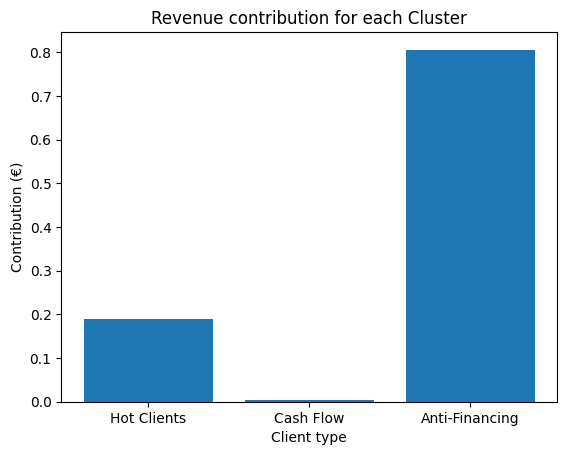

In [147]:
categories = ['Hot Clients', 'Cash Flow', 'Anti-Financing']


revenues = [Hot_clients_revenue, Cash_flow_revenue, Anti_financing_revenue]


total_revenue = sum(revenues)


contributions = [revenue / total_revenue for revenue in revenues]

# Create plot
plt.bar(categories, contributions)
plt.xlabel('Client type')
plt.ylabel('Contribution (€)')
plt.title('Revenue contribution for each Cluster')

# show
plt.show()